In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

# machine learning model
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, cross_val_score)
import lightgbm as lgb


# oversampling
from imblearn.over_sampling import SVMSMOTE

# hyperparameter tuning
import optuna

In [3]:
# function for feature engineering
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

[LightGBM] [Warning] feature_fraction is set=0.4386219301785611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4386219301785611
[LightGBM] [Warning] lambda_l1 is set=4.9087660802805254e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.9087660802805254e-08
[LightGBM] [Warning] lambda_l2 is set=7.107814046559069e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.107814046559069e-08
[LightGBM] [Warning] bagging_fraction is set=0.5853318649736283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5853318649736283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4386219301785611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4386219301785611
[LightGBM] [Warning] lambda_l1 is set=4.9087660802805254e-08, reg_alpha=0.0 

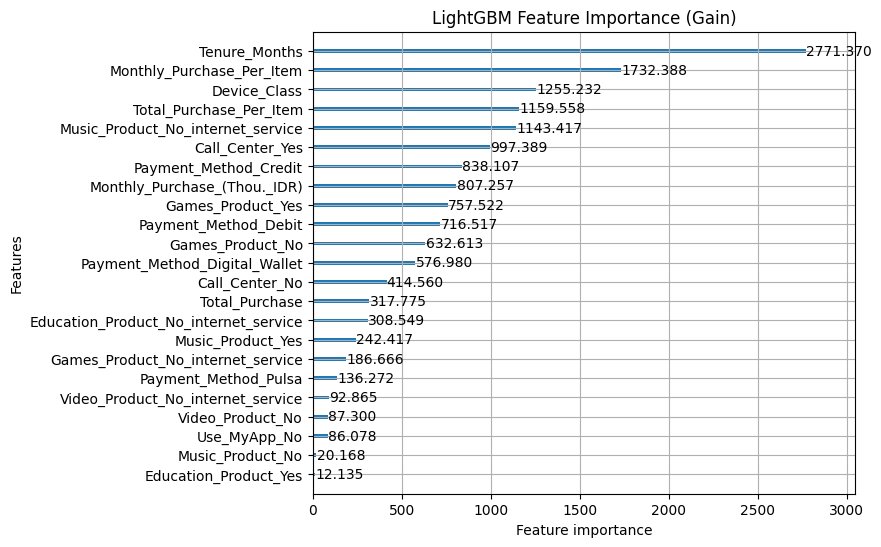

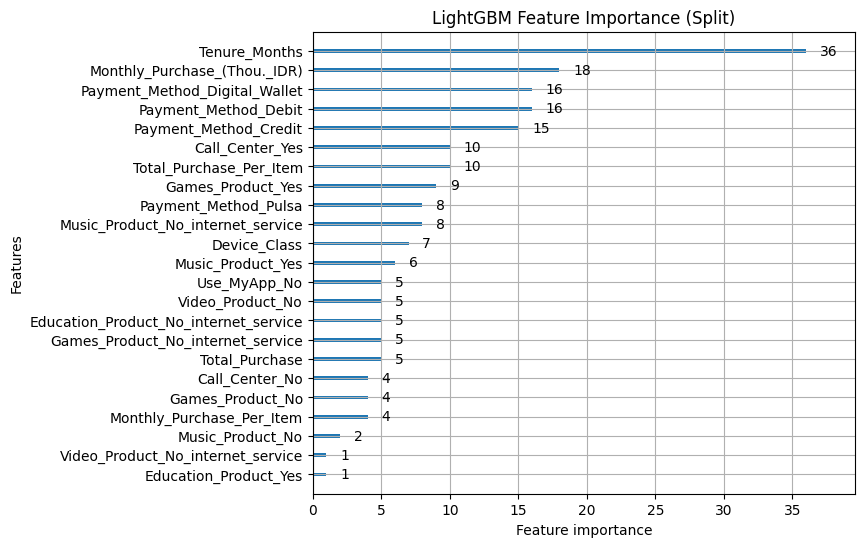

In [5]:
# load data
# ==============================================
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()


# Data Preparation
# ==============================================
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})  # encode Churn Label
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Monthly Purchase Per Item"] = df[["Monthly Purchase (Thou. IDR)", "Products Used"]]\
    .apply(lambda x: x["Monthly Purchase (Thou. IDR)"] / x["Products Used"] if x["Products Used"] > 0 else x["Monthly Purchase (Thou. IDR)"], axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]  # feature engineering
df["Total Purchase Per Item"] = df["Tenure Months"] * df["Monthly Purchase Per Item"]  # feature engineering
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling for balancing dataset
# ==============================================
smote = SVMSMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

# Scale data (tree model don't need for scaling)
# ==============================================
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  # <<<<<<<<<<<<< SCALING
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)  # <<<<<<<<<<<<< SCALING
# X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING
    
model = lgb.LGBMClassifier(**{
        "lambda_l1": 4.9087660802805254e-08,
        "lambda_l2": 7.107814046559069e-08,
        "num_leaves": 3,
        "feature_fraction": 0.4386219301785611,
        "bagging_fraction": 0.5853318649736283,
        "bagging_freq": 1,
        "min_child_samples": 200,
        "random_state": 42
    })
model.fit(X_train, y_train)



# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()